In [31]:
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import Select, WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from bs4 import BeautifulSoup
import pandas as pd
import time

# 셀레니움 기본 설정
options = Options()
# options.add_argument('--headless')  # 필요하면 주석 해제해서 백그라운드 실행
driver = webdriver.Chrome(options=options)
url = "http://www.kmta.or.kr/kr/data/stats_price_month_pork.php"
driver.get(url)
driver.maximize_window()
time.sleep(2)

# 연도 드롭다운 요소 가져오기
select_element = Select(driver.find_element(By.CSS_SELECTOR,
    "body > div.container > div.contents.p_stats > form > div > span > select"))

# 드롭다운에서 모든 옵션 텍스트 추출
options_all = select_element.options
year_texts = [opt.text.strip() for opt in options_all]
year_to_index = {text: i for i, text in enumerate(year_texts)}

# 수집할 연도 목록
target_years = [str(y) for y in range(2015, 2025)]

# 결과 저장 리스트
all_data = []

# 각 연도에 대해 반복
for year in target_years:
    print(f"🔍 {year}년 데이터 수집 중...")

    if year not in year_to_index:
        print(f"⚠️ {year}년 옵션 없음 → 스킵")
        continue

    idx = year_to_index[year]
    select_element.select_by_index(idx)

    # 테이블 로딩 대기
    WebDriverWait(driver, 10).until(
        EC.presence_of_element_located((By.CSS_SELECTOR, "table.table01"))
    )

    # 현재 페이지 HTML 파싱
    soup = BeautifulSoup(driver.page_source, 'html.parser')
    table = soup.find('table', class_='table01')
    if not table:
        print(f"❌ {year}년: 테이블을 찾을 수 없습니다.")
        continue

    rows = table.find_all('tr')

    for i, row in enumerate(rows[1:]):  # 헤더 제외
        cols = row.find_all(['th', 'td'])
        if len(cols) >= 4:
            month = f"{i+1:02}월"
            wholesale_price = cols[3].text.strip().replace(',', '')

            try:
                price = int(wholesale_price)
                all_data.append({
                    "연도": int(year),
                    "월": month,
                    "도매가격": price
                })
            except ValueError:
                print(f"⚠️ {year} {month}: 숫자 변환 실패 → '{wholesale_price}'")
                continue

driver.quit()

# 데이터프레임 정리 및 출력
df = pd.DataFrame(all_data)
df = df.sort_values(by=["연도", "월"])

# 출력
print(df)

# 저장


🔍 2015년 데이터 수집 중...


TimeoutException: Message: 
Stacktrace:
#0 0x5df4a9516ffa <unknown>
#1 0x5df4a8fd5970 <unknown>
#2 0x5df4a9027385 <unknown>
#3 0x5df4a90275b1 <unknown>
#4 0x5df4a90763c4 <unknown>
#5 0x5df4a904d2bd <unknown>
#6 0x5df4a907370c <unknown>
#7 0x5df4a904d063 <unknown>
#8 0x5df4a9019328 <unknown>
#9 0x5df4a901a491 <unknown>
#10 0x5df4a94de42b <unknown>
#11 0x5df4a94e22ec <unknown>
#12 0x5df4a94c5a22 <unknown>
#13 0x5df4a94e2e64 <unknown>
#14 0x5df4a94a9bef <unknown>
#15 0x5df4a9505558 <unknown>
#16 0x5df4a9505736 <unknown>
#17 0x5df4a9515e76 <unknown>
#18 0x7d6ef4e94ac3 <unknown>


In [32]:
import requests
from bs4 import BeautifulSoup

# URL 설정
url = "http://www.kmta.or.kr/kr/data/stats_price_year.php"

# 웹 페이지 요청
response = requests.get(url)
response.encoding = 'utf-8'  # 한글 인코딩 처리

# HTML 파싱
soup = BeautifulSoup(response.text, 'html.parser')

# 표 선택 (class='p_stats' 내 table)
table = soup.select_one("div.contents.p_stats > table")

# 원하는 행 번호: 3~5 (즉, 93~95년)
for year_offset, row_index in enumerate(range(3, 6)):  # 3, 4, 5
    row = table.select_one(f"tr:nth-child({row_index})")
    if row:
        cells = row.find_all("td")
        if len(cells) >= 5:
            cssdi = cells[4].text.strip()
            year = 1993 + year_offset
            print(f"{year}년 CSSDI: {cssdi}")
        else:
            print(f"{1993 + year_offset}년 데이터가 부족합니다.")
    else:
        print(f"{1993 + year_offset}년 행을 찾을 수 없습니다.")


1993년 CSSDI: 971
1994년 CSSDI: 1,287
1995년 CSSDI: 1,242


In [ ]:
body > div.container > div.contents.p_stats > table > tbody > tr:nth-child(4) > td:nth-child(5)

In [60]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

# URL
url = "http://www.kmta.or.kr/kr/data/stats_price_year.php"

# 요청
response = requests.get(url)
response.encoding = 'utf-8'

# 파싱
soup = BeautifulSoup(response.text, 'html.parser')

# 표 선택
table = soup.select_one("div.contents.p_stats > table")
rows = table.select("tr")

# 연도 및 값 수집
data = []
start_year = 1993
for i, row in enumerate(rows[2:], start=0):  # 헤더 2줄 건너뜀
    if start_year + i > 2024:
        break  # 2024년까지만
    cells = row.find_all("td")
    if len(cells) >= 4:
        value = cells[3].get_text(strip=True)
        year = start_year + i
        data.append({"연도": f"{year}", "값": value})

# DataFrame 생성
df = pd.DataFrame(data)

# 출력
print(df)


      연도      값
0   1993  2,151
1   1994  2,373
2   1995  2,298
3   1996  2,490
4   1997  2,422
5   1998  2,514
6   1999  3,017
7   2000  2,499
8   2001  2,599
9   2002  2,645
10  2003  2,444
11  2004  3,479
12  2005  3,730
13  2006  3,649
14  2007  3,247
15  2008  4,046
16  2009  4,449
17  2010  4,232
18  2011  5,808
19  2012  3,974
20  2013  3,570
21  2014  4,741
22  2015  4,939
23  2016  4,617
24  2017  4,947
25  2018  4,362
26  2019  3,843
27  2020  4,216
28  2021  4,722
29  2022  5,227
30  2023  5,134
31  2024  5,239


In [50]:
import pandas as pd
import pymysql  # 또는 psycopg2 for PostgreSQL

# RDS 접속 정보 (예시)
host = 'database-1.cba44miw26by.ap-northeast-2.rds.amazonaws.com'
port = 3306
user = 'psy'
password = '0000'
database = 'pig'

# 연결
conn = pymysql.connect(
    host=host,
    port=port,
    user=user,
    password=password,
    database=database,
    charset='utf8mb4'
)

# SQL 쿼리 실행
query = "SELECT * FROM feed"
feed_table = pd.read_sql(query, conn)

# 연결 종료
conn.close()


/tmp/ipykernel_193615/3800871959.py:23: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  feed_table = pd.read_sql(query, conn)


In [57]:
print(feed_table)


    year  corn_price  exchange_rate  krw_based_price     사료비  corn_1kg  \
0   2015     3.76673        1129.99          4256.37  169920   156.484   
1   2015     3.76673        1129.99          4256.37  169008   156.484   
2   2015     3.76673        1129.99          4256.37  165461   156.484   
3   2015     3.76673        1129.99          4256.37  166465   156.484   
4   2015     3.76673        1129.99          4256.37  167173   156.484   
5   2016     3.58454        1158.69          4153.36  166773   152.697   
6   2016     3.58454        1158.69          4153.36  173808   152.697   
7   2016     3.58454        1158.69          4153.36  168637   152.697   
8   2016     3.58454        1158.69          4153.36  151714   152.697   
9   2016     3.58454        1158.69          4153.36  158804   152.697   
10  2017     3.59224        1129.93          4058.97  171207   149.227   
11  2017     3.59224        1129.93          4058.97  175978   149.227   
12  2017     3.59224        1129.93   

/tmp/ipykernel_193615/1811966515.py:20: UserWarning: Glyph 50672 (\N{HANGUL SYLLABLE YEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_193615/1811966515.py:20: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_193615/1811966515.py:20: UserWarning: Glyph 44050 (\N{HANGUL SYLLABLE GABS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_193615/1811966515.py:20: UserWarning: Glyph 48324 (\N{HANGUL SYLLABLE BYEOL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_193615/1811966515.py:20: UserWarning: Glyph 52628 (\N{HANGUL SYLLABLE CU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_193615/1811966515.py:20: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


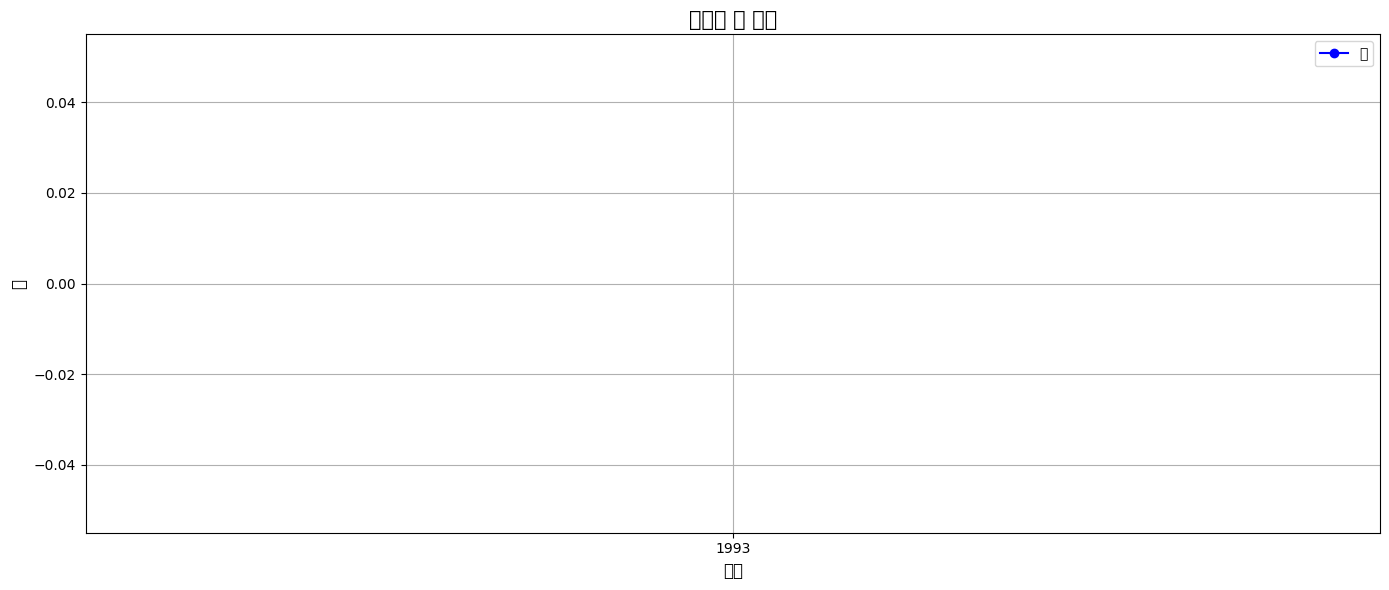

In [62]:
import matplotlib.pyplot as plt

# 값 열을 숫자로 변환 (필요한 경우)
df['값'] = pd.to_numeric(df['값'], errors='coerce')

# 그래프 설정
plt.figure(figsize=(14, 6))

# 선 그래프 그리기
plt.plot(df['연도'], df['값'], label='값', marker='o', color='blue')

# 그래프 제목 및 축 레이블 설정
plt.title('연도별 값 추이', fontsize=15)
plt.xlabel('연도', fontsize=12)
plt.ylabel('값', fontsize=12)

# 그래프 설정
plt.grid(True)
plt.legend()
plt.tight_layout()

# 그래프 출력
plt.show()

/tmp/ipykernel_193615/3539888305.py:38: UserWarning: Glyph 50672 (\N{HANGUL SYLLABLE YEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_193615/3539888305.py:38: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_193615/3539888305.py:38: UserWarning: Glyph 44050 (\N{HANGUL SYLLABLE GABS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_193615/3539888305.py:38: UserWarning: Glyph 48324 (\N{HANGUL SYLLABLE BYEOL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_193615/3539888305.py:38: UserWarning: Glyph 52628 (\N{HANGUL SYLLABLE CU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_193615/3539888305.py:38: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/sungyoon/project1/.venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 44050 (\N{HANG

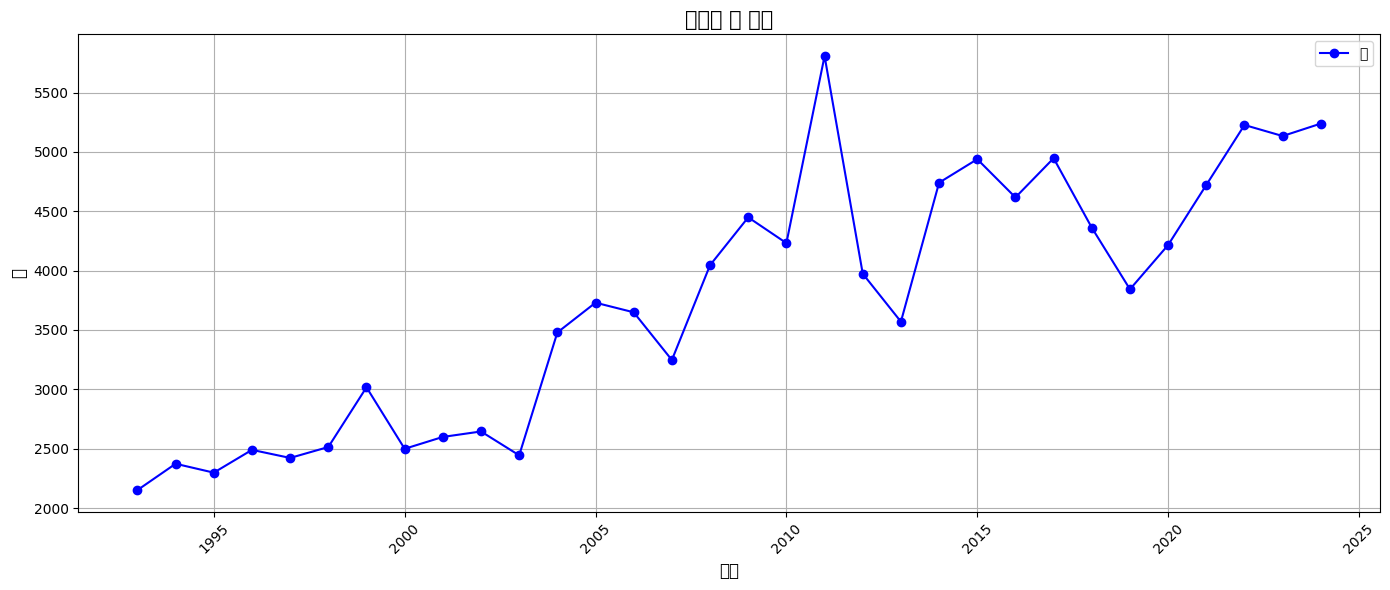

In [64]:
import matplotlib.pyplot as plt
import pandas as pd

# 데이터프레임 생성
data = {
    "연도": [
        1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011,
        2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024
    ],
    "값": [
        "2,151", "2,373", "2,298", "2,490", "2,422", "2,514", "3,017", "2,499", "2,599", "2,645", "2,444", "3,479",
        "3,730", "3,649", "3,247", "4,046", "4,449", "4,232", "5,808", "3,974", "3,570", "4,741", "4,939", "4,617",
        "4,947", "4,362", "3,843", "4,216", "4,722", "5,227", "5,134", "5,239"
    ]
}
df = pd.DataFrame(data)

# 값 열을 숫자로 변환
df['값'] = df['값'].str.replace(',', '').astype(int)

# 그래프 설정
plt.figure(figsize=(14, 6))

# 선 그래프 그리기
plt.plot(df['연도'], df['값'], label='값', marker='o', color='blue')

# 그래프 제목 및 축 레이블 설정
plt.title('연도별 값 추이', fontsize=15)
plt.xlabel('연도', fontsize=12)
plt.ylabel('값', fontsize=12)

# x축 레이블 회전 (필요한 경우)
plt.xticks(rotation=45)

# 그래프 설정
plt.grid(True)
plt.legend()
plt.tight_layout()

# 그래프 출력
plt.show()

/tmp/ipykernel_193615/2530316616.py:47: UserWarning: Glyph 50900 (\N{HANGUL SYLLABLE WEOL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_193615/2530316616.py:47: UserWarning: Glyph 49324 (\N{HANGUL SYLLABLE SA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_193615/2530316616.py:47: UserWarning: Glyph 47308 (\N{HANGUL SYLLABLE RYO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_193615/2530316616.py:47: UserWarning: Glyph 48708 (\N{HANGUL SYLLABLE BI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_193615/2530316616.py:47: UserWarning: Glyph 48324 (\N{HANGUL SYLLABLE BYEOL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_193615/2530316616.py:47: UserWarning: Glyph 52628 (\N{HANGUL SYLLABLE CU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_193615/2530316616.py:47: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from font(s) DejaVu Sans.
 

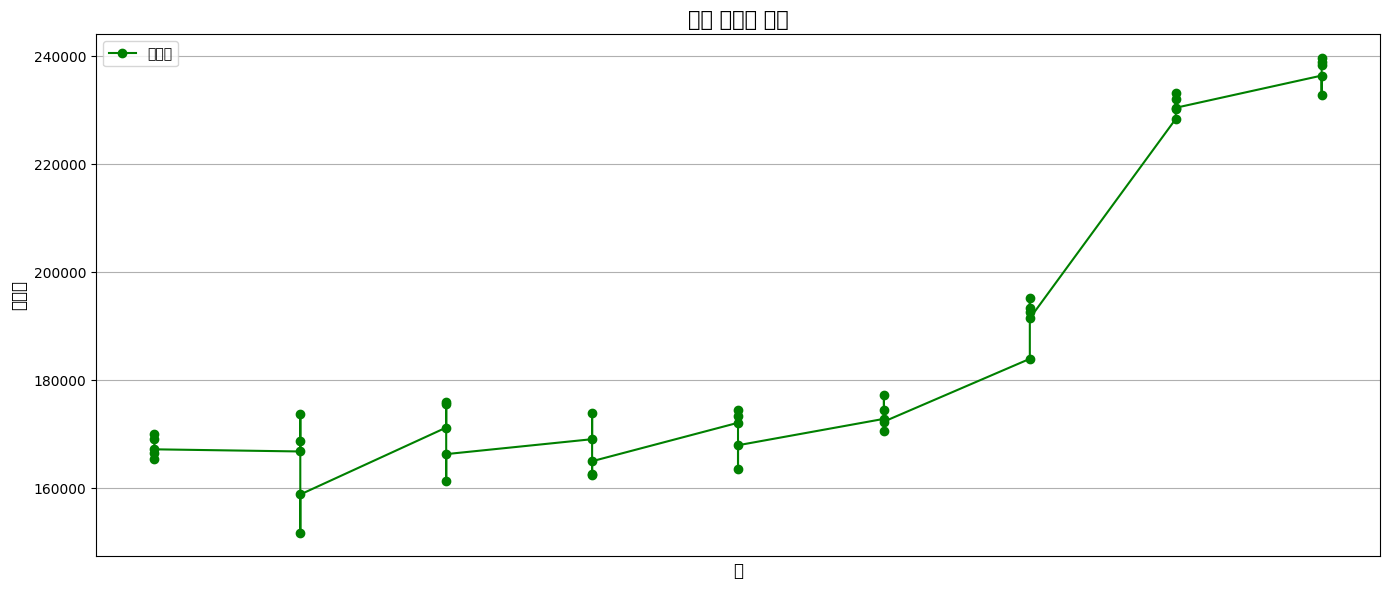

In [82]:
import mysql.connector
import pandas as pd
import matplotlib.pyplot as plt

# MySQL 연결 설정
conn = mysql.connector.connect(
    host='database-1.cba44miw26by.ap-northeast-2.rds.amazonaws.com',
    user='psy',
    password='0000',
    database='pig'
)
cursor = conn.cursor()

# feed_price 테이블에서 데이터 가져오기
query = "SELECT year, 사료비 FROM feed"
cursor.execute(query)

# 결과를 데이터프레임으로 변환
rows = cursor.fetchall()
columns = [desc[0] for desc in cursor.description]  # 열 이름 가져오기
feed_df = pd.DataFrame(rows, columns=columns)

# MySQL 연결 종료
cursor.close()
conn.close()

# month 열을 datetime 형식으로 변환
feed_df['year'] = pd.to_datetime(feed_df['year'])

# 그래프 설정
plt.figure(figsize=(14, 6))

# 선 그래프 그리기
plt.plot(feed_df['year'], feed_df['사료비'], label='사료비', marker='o', color='green')

# 그래프 제목 및 축 레이블 설정
plt.title('월별 사료비 추이', fontsize=15)
plt.xlabel('월', fontsize=12)
plt.ylabel('사료비', fontsize=12)

# x축 레이블 회전
plt.xticks(rotation=45)

# 그래프 설정
plt.grid(True)
plt.legend()
plt.tight_layout()

# 그래프 출력
plt.show()

연도별 평균 사료비:
   year            사료비
0  1970  185718.133333


/tmp/ipykernel_193615/2486561179.py:57: UserWarning: Glyph 50672 (\N{HANGUL SYLLABLE YEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_193615/2486561179.py:57: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_193615/2486561179.py:57: UserWarning: Glyph 54217 (\N{HANGUL SYLLABLE PYEONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_193615/2486561179.py:57: UserWarning: Glyph 44512 (\N{HANGUL SYLLABLE GYUN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_193615/2486561179.py:57: UserWarning: Glyph 49324 (\N{HANGUL SYLLABLE SA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_193615/2486561179.py:57: UserWarning: Glyph 47308 (\N{HANGUL SYLLABLE RYO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_193615/2486561179.py:57: UserWarning: Glyph 48708 (\N{HANGUL SYLLABLE BI}) missing from font(s) DejaVu San

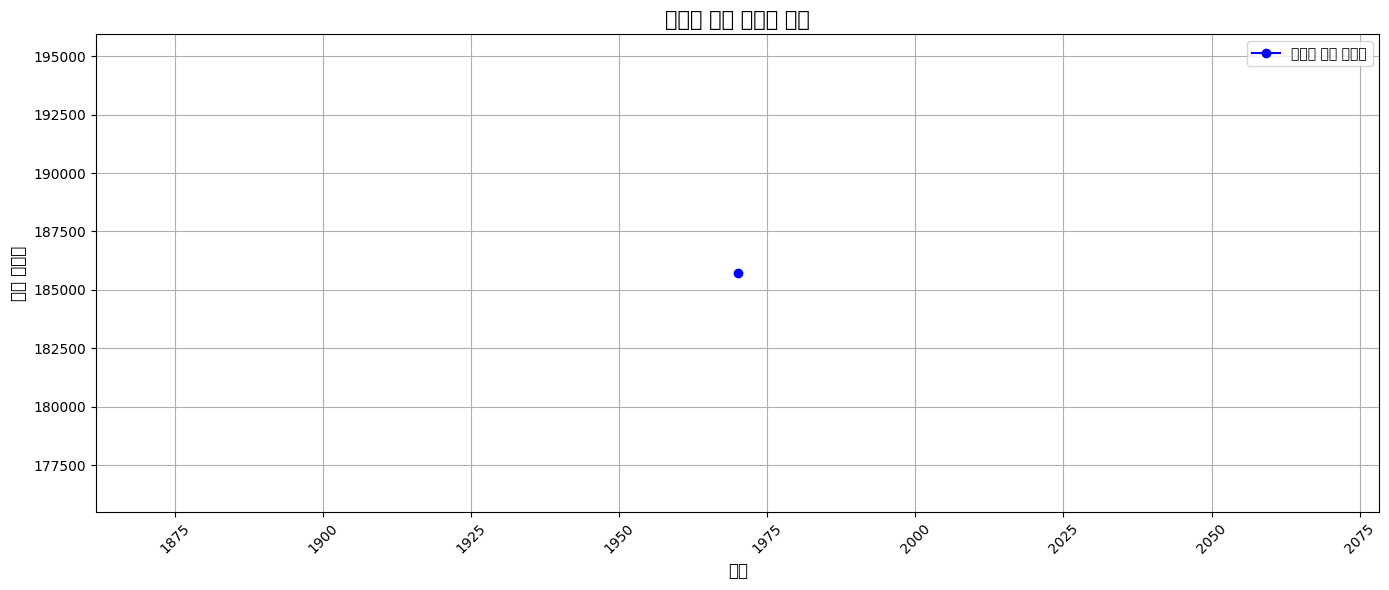

In [78]:
import mysql.connector
import pandas as pd
import matplotlib.pyplot as plt

# MySQL 연결 설정
conn = mysql.connector.connect(
    host='database-1.cba44miw26by.ap-northeast-2.rds.amazonaws.com',
    user='psy',
    password='0000',
    database='pig'
)
cursor = conn.cursor()

# feed 테이블에서 데이터 가져오기
query = "SELECT year, 사료비 FROM feed"
cursor.execute(query)

# 결과를 데이터프레임으로 변환
rows = cursor.fetchall()
columns = [desc[0] for desc in cursor.description]  # 열 이름 가져오기
feed_df = pd.DataFrame(rows, columns=columns)

# MySQL 연결 종료
cursor.close()
conn.close()

# year 열을 datetime 형식으로 변환
feed_df['year'] = pd.to_datetime(feed_df['year'], errors='coerce').dt.year

# 사료비 열을 숫자로 변환
feed_df['사료비'] = pd.to_numeric(feed_df['사료비'], errors='coerce')

# 연도별 평균 사료비 계산
yearly_avg = feed_df.groupby('year', as_index=False)['사료비'].mean()

# 데이터 확인
print("연도별 평균 사료비:")
print(yearly_avg)

# 그래프 설정
plt.figure(figsize=(14, 6))

# 선 그래프 그리기
plt.plot(yearly_avg['year'], yearly_avg['사료비'], label='연도별 평균 사료비', marker='o', color='blue')

# 그래프 제목 및 축 레이블 설정
plt.title('연도별 평균 사료비 추이', fontsize=15)
plt.xlabel('연도', fontsize=12)
plt.ylabel('평균 사료비', fontsize=12)

# x축 레이블 회전
plt.xticks(rotation=45)

# 그래프 설정
plt.grid(True)
plt.legend()
plt.tight_layout()

# 그래프 출력
plt.show()

/tmp/ipykernel_193615/108869536.py:35: UserWarning: Glyph 50672 (\N{HANGUL SYLLABLE YEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_193615/108869536.py:35: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_193615/108869536.py:35: UserWarning: Glyph 44050 (\N{HANGUL SYLLABLE GABS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_193615/108869536.py:35: UserWarning: Glyph 48324 (\N{HANGUL SYLLABLE BYEOL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_193615/108869536.py:35: UserWarning: Glyph 52628 (\N{HANGUL SYLLABLE CU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_193615/108869536.py:35: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/sungyoon/project1/.venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 44050 (\N{HANGUL SYL

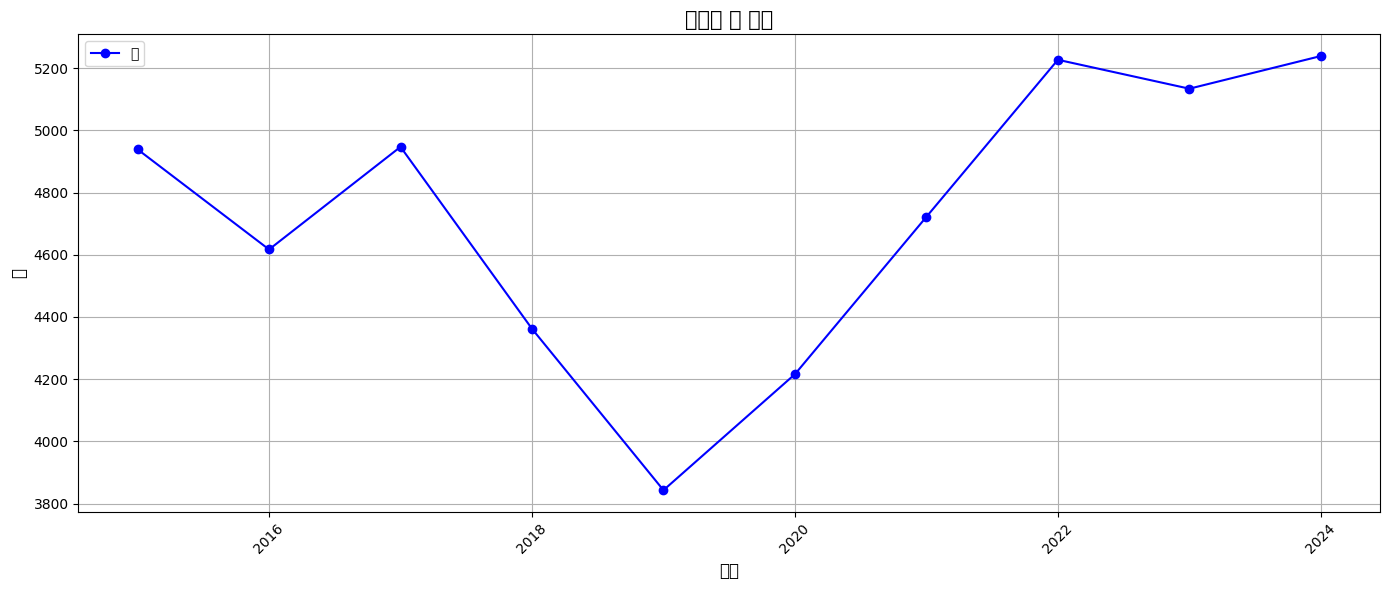

In [79]:
import matplotlib.pyplot as plt
import pandas as pd

# 데이터프레임 생성
data = {
    "연도": [
        2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024
    ],
    "값": [
         "4,939", "4,617", "4,947", "4,362", "3,843", "4,216", "4,722", "5,227", "5,134", "5,239"
    ]
}
df = pd.DataFrame(data)

# 값 열을 숫자로 변환
df['값'] = df['값'].str.replace(',', '').astype(int)

# 그래프 설정
plt.figure(figsize=(14, 6))

# 선 그래프 그리기
plt.plot(df['연도'], df['값'], label='값', marker='o', color='blue')

# 그래프 제목 및 축 레이블 설정
plt.title('연도별 값 추이', fontsize=15)
plt.xlabel('연도', fontsize=12)
plt.ylabel('값', fontsize=12)

# x축 레이블 회전 (필요한 경우)
plt.xticks(rotation=45)

# 그래프 설정
plt.grid(True)
plt.legend()
plt.tight_layout()

# 그래프 출력
plt.show()

/tmp/ipykernel_193615/2747491993.py:67: UserWarning: Glyph 50672 (\N{HANGUL SYLLABLE YEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_193615/2747491993.py:67: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_193615/2747491993.py:67: UserWarning: Glyph 44050 (\N{HANGUL SYLLABLE GABS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_193615/2747491993.py:67: UserWarning: Glyph 49324 (\N{HANGUL SYLLABLE SA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_193615/2747491993.py:67: UserWarning: Glyph 47308 (\N{HANGUL SYLLABLE RYO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_193615/2747491993.py:67: UserWarning: Glyph 48708 (\N{HANGUL SYLLABLE BI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_193615/2747491993.py:67: UserWarning: Glyph 50752 (\N{HANGUL SYLLABLE WA}) missing from font(s) DejaVu Sans.
 

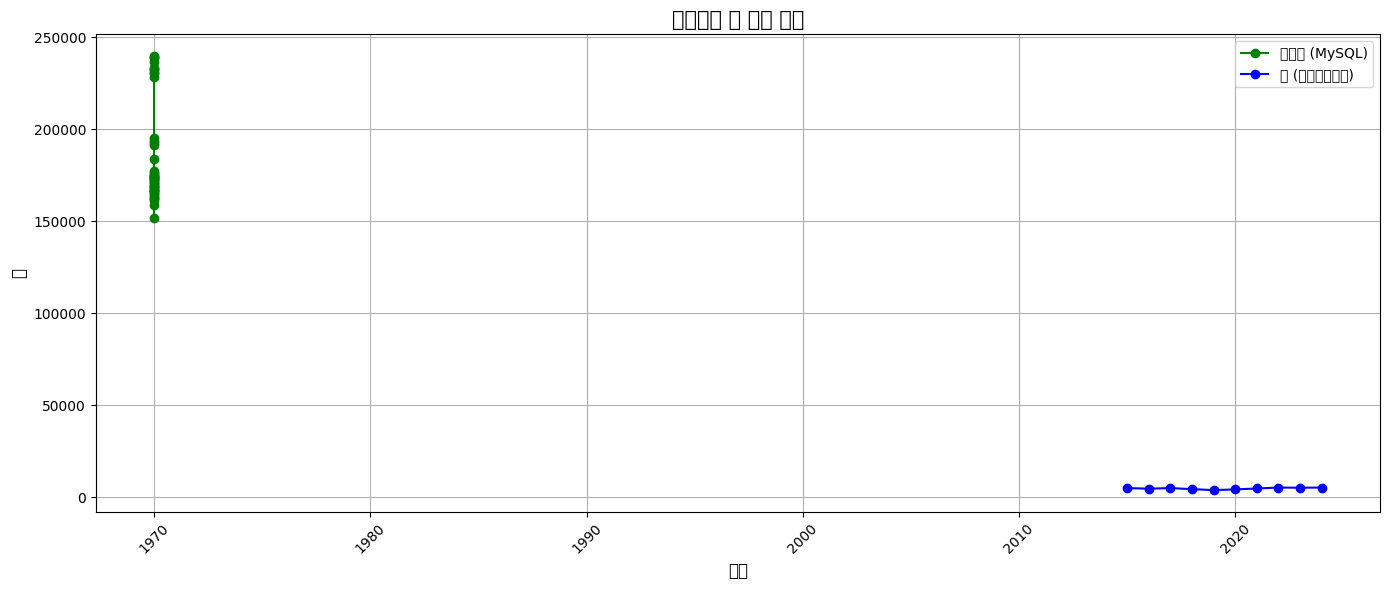

In [83]:
import mysql.connector
import pandas as pd
import matplotlib.pyplot as plt

# MySQL 연결 설정
conn = mysql.connector.connect(
    host='database-1.cba44miw26by.ap-northeast-2.rds.amazonaws.com',
    user='psy',
    password='0000',
    database='pig'
)
cursor = conn.cursor()

# feed_price 테이블에서 데이터 가져오기
query = "SELECT year, 사료비 FROM feed"
cursor.execute(query)

# 결과를 데이터프레임으로 변환
rows = cursor.fetchall()
columns = [desc[0] for desc in cursor.description]  # 열 이름 가져오기
feed_df = pd.DataFrame(rows, columns=columns)

# MySQL 연결 종료
cursor.close()
conn.close()

# year 열을 datetime 형식으로 변환
feed_df['year'] = pd.to_datetime(feed_df['year'], errors='coerce').dt.year

# 사료비 열을 숫자로 변환
feed_df['사료비'] = pd.to_numeric(feed_df['사료비'], errors='coerce')

# 두 번째 데이터프레임 생성
data = {
    "연도": [
        2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024
    ],
    "값": [
        "4,939", "4,617", "4,947", "4,362", "3,843", "4,216", "4,722", "5,227", "5,134", "5,239"
    ]
}
df = pd.DataFrame(data)

# 값 열을 숫자로 변환
df['값'] = df['값'].str.replace(',', '').astype(int)

# 그래프 설정
plt.figure(figsize=(14, 6))

# 첫 번째 그래프 (feed_df)
plt.plot(feed_df['year'], feed_df['사료비'], label='사료비 (MySQL)', marker='o', color='green')

# 두 번째 그래프 (df)
plt.plot(df['연도'], df['값'], label='값 (데이터프레임)', marker='o', color='blue')

# 그래프 제목 및 축 레이블 설정
plt.title('사료비와 값 추이 비교', fontsize=15)
plt.xlabel('연도', fontsize=12)
plt.ylabel('값', fontsize=12)

# x축 레이블 회전
plt.xticks(rotation=45)

# 그래프 설정
plt.grid(True)
plt.legend()
plt.tight_layout()

# 그래프 출력
plt.show()

/tmp/ipykernel_193615/2747491993.py:67: UserWarning: Glyph 50672 (\N{HANGUL SYLLABLE YEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_193615/2747491993.py:67: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_193615/2747491993.py:67: UserWarning: Glyph 44050 (\N{HANGUL SYLLABLE GABS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_193615/2747491993.py:67: UserWarning: Glyph 49324 (\N{HANGUL SYLLABLE SA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_193615/2747491993.py:67: UserWarning: Glyph 47308 (\N{HANGUL SYLLABLE RYO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_193615/2747491993.py:67: UserWarning: Glyph 48708 (\N{HANGUL SYLLABLE BI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_193615/2747491993.py:67: UserWarning: Glyph 50752 (\N{HANGUL SYLLABLE WA}) missing from font(s) DejaVu Sans.
 

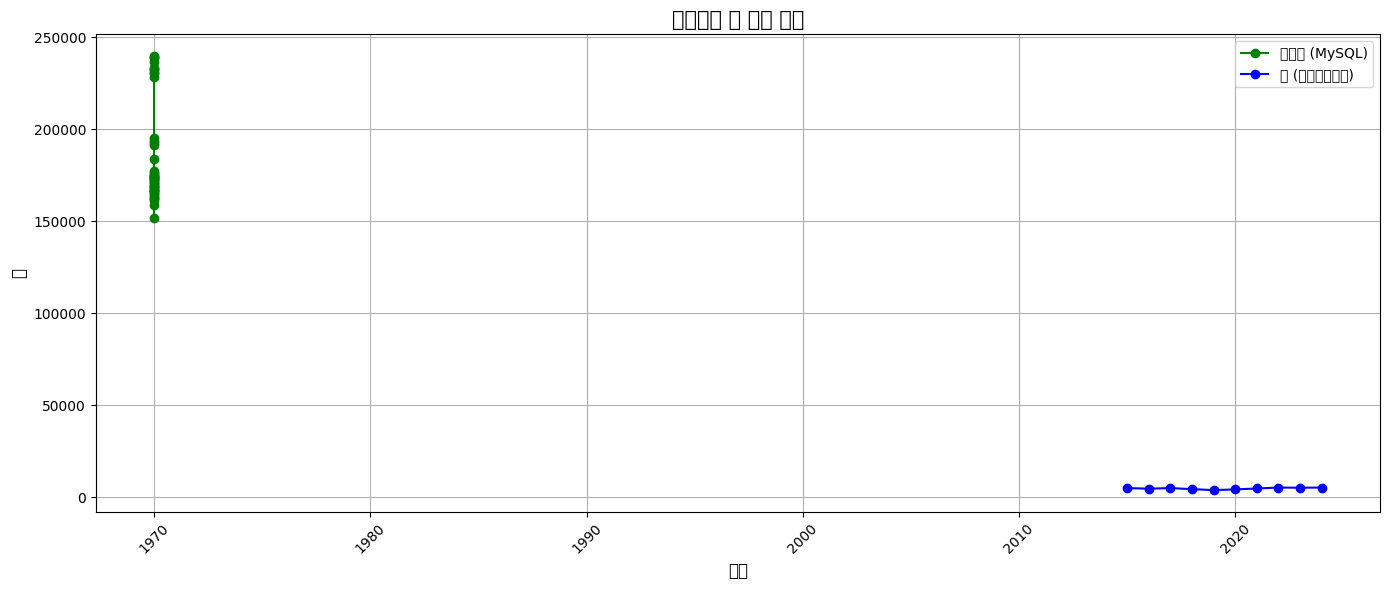

In [84]:
import mysql.connector
import pandas as pd
import matplotlib.pyplot as plt

# MySQL 연결 설정
conn = mysql.connector.connect(
    host='database-1.cba44miw26by.ap-northeast-2.rds.amazonaws.com',
    user='psy',
    password='0000',
    database='pig'
)
cursor = conn.cursor()

# feed_price 테이블에서 데이터 가져오기
query = "SELECT year, 사료비 FROM feed"
cursor.execute(query)

# 결과를 데이터프레임으로 변환
rows = cursor.fetchall()
columns = [desc[0] for desc in cursor.description]  # 열 이름 가져오기
feed_df = pd.DataFrame(rows, columns=columns)

# MySQL 연결 종료
cursor.close()
conn.close()

# year 열을 datetime 형식으로 변환
feed_df['year'] = pd.to_datetime(feed_df['year'], errors='coerce').dt.year

# 사료비 열을 숫자로 변환
feed_df['사료비'] = pd.to_numeric(feed_df['사료비'], errors='coerce')

# 두 번째 데이터프레임 생성
data = {
    "연도": [
        2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024
    ],
    "값": [
        "4,939", "4,617", "4,947", "4,362", "3,843", "4,216", "4,722", "5,227", "5,134", "5,239"
    ]
}
df = pd.DataFrame(data)

# 값 열을 숫자로 변환
df['값'] = df['값'].str.replace(',', '').astype(int)

# 그래프 설정
plt.figure(figsize=(14, 6))

# 첫 번째 그래프 (feed_df)
plt.plot(feed_df['year'], feed_df['사료비'], label='사료비 (MySQL)', marker='o', color='green')

# 두 번째 그래프 (df)
plt.plot(df['연도'], df['값'], label='값 (데이터프레임)', marker='o', color='blue')

# 그래프 제목 및 축 레이블 설정
plt.title('사료비와 값 추이 비교', fontsize=15)
plt.xlabel('연도', fontsize=12)
plt.ylabel('값', fontsize=12)

# x축 레이블 회전
plt.xticks(rotation=45)

# 그래프 설정
plt.grid(True)
plt.legend()
plt.tight_layout()

# 그래프 출력
plt.show()